<a href="https://colab.research.google.com/github/giorginolab/Markov-Tutorial-UniPD-2023/blob/main/3_Markov_Python_Deeptime_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !conda install -q deeptime
%pip install deeptime 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import deeptime as dt

# 3 States: the weather example


A "1D" example with 3 states.

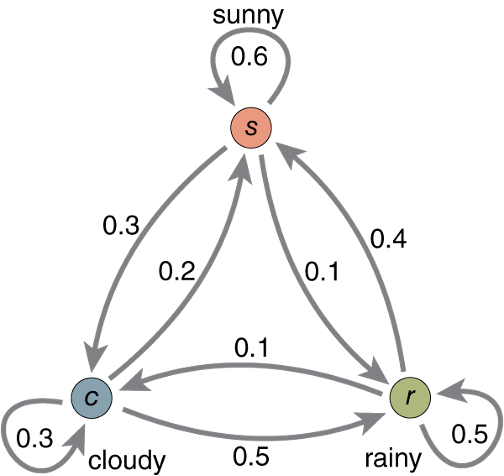

In [3]:
Pij = np.array([[0.6, 0.3, 0.1],
               [0.2, 0.3, 0.5],
               [0.4, 0.1, 0.5]])


In [4]:
def sampleP(P, x0=0, k=10):
  """Sample the discrete-time Markov chain with given transition matrix P,
     starting from state x0, n samples"""
  import random
  r = []
  Nstates, _ = P.shape  # Size of the matrix
  for i in range(k):
    P_current_row=P[x0,:]
    x=random.choices(range(Nstates), weights=P_current_row)
    x=x[0]              # List of size 1 to scalar
    r.append(x)
    x0=x
  return r


In [5]:
sampled = sampleP(Pij, k=1000)
sampled[:20]

[0, 0, 1, 1, 0, 1, 1, 2, 2, 0, 0, 1, 1, 1, 1, 2, 0, 0, 0, 0]

In [6]:
frequencies = np.bincount(sampled)
frequencies

array([447, 237, 316])

In [7]:
dG = -0.6 * np.log(frequencies)
dG = dG-np.min(dG)
dG

array([0.        , 0.38069907, 0.20808983])

In [8]:
# The exact asymptotic values can be computed numerically
eva, eve = np.linalg.eig(Pij.T)

print("Eigenvalues: ",eva)
print("First eigenvector, normalized to sum 1:")
print(eve[:,0]/np.sum(eve[:,0]))

Eigenvalues:  [1. +0.j  0.2+0.2j 0.2-0.2j]
First eigenvector, normalized to sum 1:
[0.44117647+0.j 0.23529412+0.j 0.32352941+0.j]


# Now a slightly less-synthetic example

Suppose 100 states in a sequence (1D). From https://deeptime-ml.github.io/latest/datasets/sdes/plot_tmatrix_1d.html#sphx-glr-datasets-sdes-plot-tmatrix-1d-py

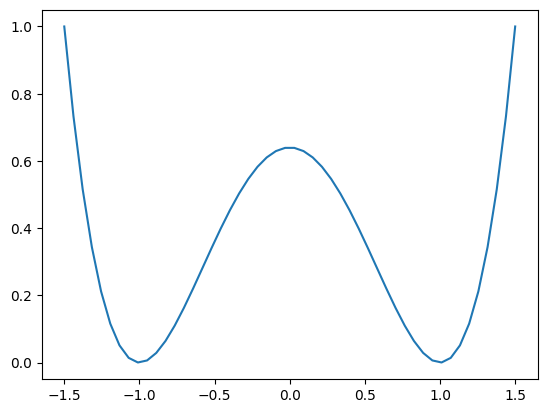

In [9]:
xs = np.linspace(-1.5, 1.5, num=50)
energies = 1/8 * (xs-1)**2 * (xs+1)**2
energies /= np.max(energies)

plt.plot(xs,energies)

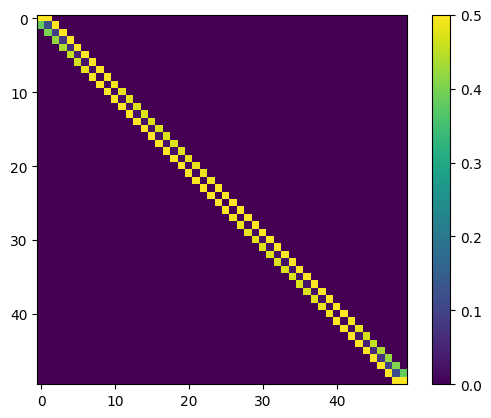

In [10]:
transition_matrix = dt.data.tmatrix_metropolis1d(energies)

plt.imshow(transition_matrix)
plt.colorbar()

In [11]:
msm = dt.markov.msm.MarkovStateModel(transition_matrix)

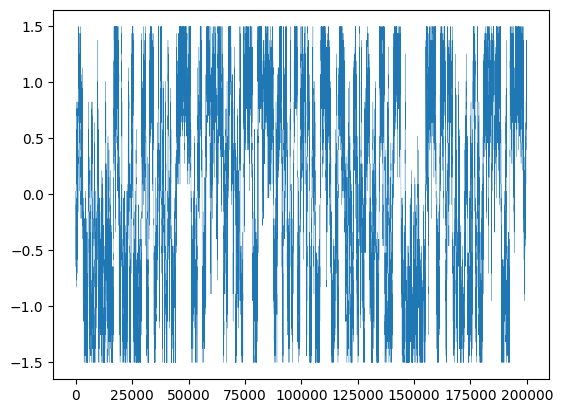

In [12]:
traj = msm.simulate(n_steps=200000)
plt.plot(xs[traj], linewidth=.2)

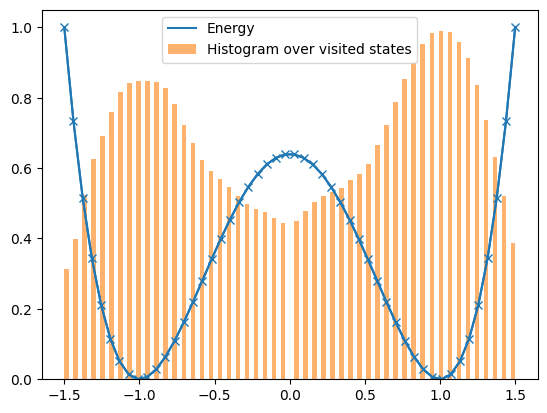

In [13]:
# Assume we are at equilibrium: histogram (frequency of states)

plt.plot(xs, energies, color='C0', label='Energy')
plt.plot(xs, energies, marker='x', color='C0')

plt.hist(xs[traj], bins=100, density=True, alpha=.6, color='C1', label='Histogram over visited states')
plt.legend()

plt.show()

In [14]:
# Now reconstruct the model from the data
estimator = dt.markov.TransitionCountEstimator(lagtime=1, count_mode="sliding")
model = estimator.fit(traj).fetch_model()

In [17]:
reconstructed_msm = dt.markov.msm.MaximumLikelihoodMSM().fit_fetch(estimator)

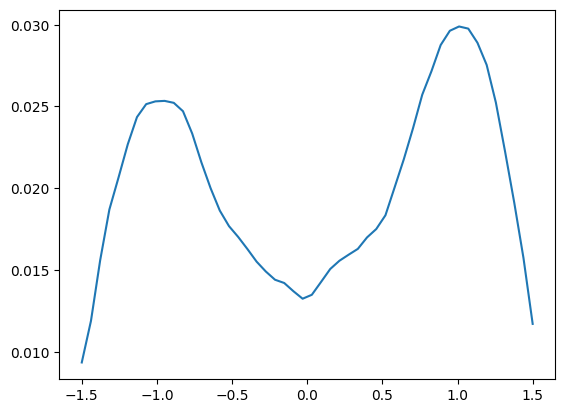

In [18]:
plt.plot(xs,reconstructed_msm.stationary_distribution)

Now let's compute a series of models at different τ values.


In [22]:
models = []
lagtimes = np.arange(1, 1000, 100)
for lagtime in lagtimes:
    counts = dt.markov.TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(traj)
    models.append(dt.markov.msm.MaximumLikelihoodMSM().fit_fetch(counts))

<Axes: >

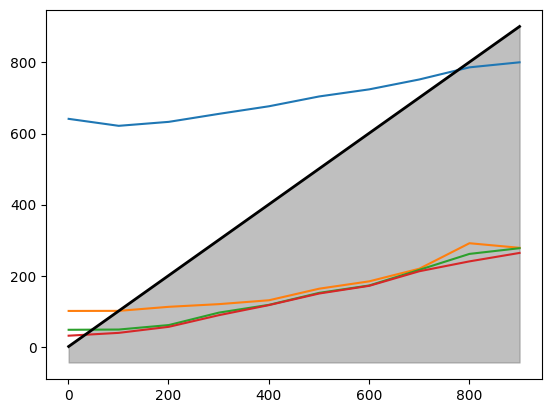

In [23]:
its_data = dt.util.validation.implied_timescales(models)

fig, ax = plt.subplots(1, 1)
dt.plots.plot_implied_timescales(its_data, n_its=4, ax=ax)

# Use real data from Fuxreiter et al.

Data from https://zenodo.org/record/7657119 related to the paper 

> Gönczi, M., Teixeira, J.M.C., Barrera-Vilarmau, S. et al. Alternatively spliced exon regulates context-dependent MEF2D higher-order assembly during myogenesis. Nat Commun 14, 1329 (2023). https://doi.org/10.1038/s41467-023-37017-7


Very important: there are 10,000 frames in each trajectory. The paper says that each trajectory corresponds to 100 ns. Hence, snapshots are taken every 10 ps.


In [25]:
# !rm -f *.netcdf   # If needed

In [30]:
!curl -JLO -C- https://zenodo.org/record/7657119/files/MEF2D_wt.prmtop
!curl -JLO -C- 'https://zenodo.org/record/7657119/files/MEF2D_wt_sim[1-3].netcdf'


** Resuming transfer from byte position 366631
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0  3846    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
curl: (23) Failed writing header

[1/3]: https://zenodo.org/record/7657119/files/MEF2D_wt_sim1.netcdf --> MEF2D_wt_sim1.netcdf
--_curl_--https://zenodo.org/record/7657119/files/MEF2D_wt_sim1.netcdf
** Resuming transfer from byte position 71080828
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0  3846    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (23) Failed writing header

[2/3]: https://zenodo.org/record/7657119/files/MEF2D_wt_sim2.netcdf --> MEF2D_wt_sim2.netcdf
--_curl_--https://zenodo.org/record/7657119/files/MEF2D_wt_sim2.netcdf
** Resuming transfer from byte pos

In [ ]:
# You can convert trajectories to xtc or DCD as follows if needed. For Pymol,
# rename the files: *.netcdf -> *.nc and load them together with the *.prmtop
# !mdconvert -o MEF2D_wt_sim1.xtc -t MEF2D_wt.prmtop MEF2D_wt_sim1.netcdf

## Load the 3 trajectories

In [32]:
#!conda install -q mdtraj
%pip install mdtraj
import mdtraj as mdt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
t1 = mdt.load('MEF2D_wt_sim1.netcdf', top='MEF2D_wt.prmtop')
t2 = mdt.load('MEF2D_wt_sim2.netcdf', top='MEF2D_wt.prmtop')
t3 = mdt.load('MEF2D_wt_sim3.netcdf', top='MEF2D_wt.prmtop')

In [34]:
print(t1.n_residues)
print(t1.n_atoms)
print(t1.n_frames)

38
588
10000


## Compute contacts

In [35]:
cont1, pairs1=mdt.compute_contacts(t1)

In [36]:
# Interpretation: rows as frames, columns are the (selected) atom pairs
cont1.shape

(10000, 595)

In [37]:
# Interpretation: rows as atom pairs, columns indicate atom1 and atom2
pairs1.shape

(595, 2)

In [38]:
pairs1[:,:]

array([[ 0,  3],
       [ 0,  4],
       [ 0,  5],
       ...,
       [32, 35],
       [32, 36],
       [33, 36]])

In [39]:
# Contacts in the first frame
cont1[0,:40]

array([0.46353683, 0.76798314, 1.1079024 , 1.3545909 , 1.5664066 ,
       1.878768  , 2.2288554 , 2.3501945 , 2.3268056 , 2.606341  ,
       2.5283515 , 2.7235374 , 2.8238664 , 3.096319  , 3.2061412 ,
       3.1927004 , 3.675829  , 3.8558087 , 4.177997  , 4.477379  ,
       4.6684384 , 4.456918  , 4.587924  , 5.0625763 , 4.8889513 ,
       5.3709083 , 5.5338087 , 5.7065053 , 5.9339957 , 6.211272  ,
       6.553864  , 6.8132963 , 6.7774634 , 6.492945  , 0.6213359 ,
       0.8906114 , 1.051608  , 1.3223318 , 1.6169856 , 1.9519491 ],
      dtype=float32)

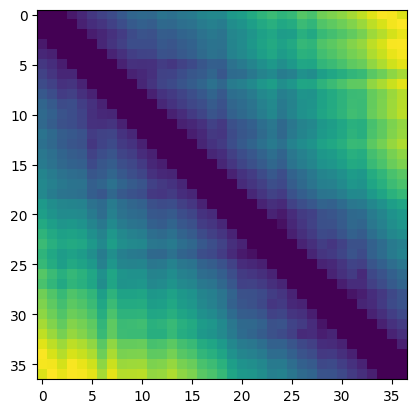

In [40]:
plt.imshow(mdt.geometry.squareform(cont1, pairs1)[0,:,:])

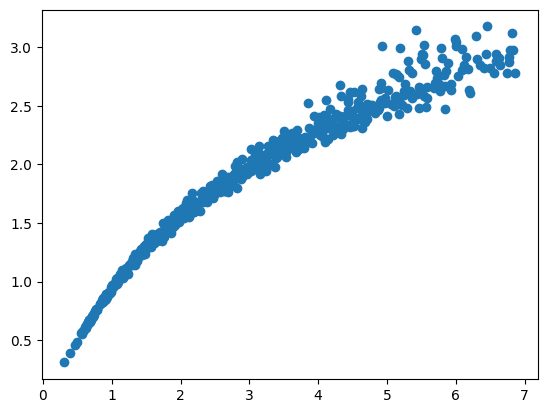

In [41]:
# The soft_min transformation is not clear
tmp,_=mdt.compute_contacts(t1, soft_min=True)
plt.scatter(cont1[0,:],tmp[0,:])

## Project with TICA

In [42]:
from deeptime.decomposition import TICA
tica = TICA(dim=2, lagtime=5)
data_tica = tica.fit(cont1)
model1 = tica.fetch_model()

In [43]:
prj1=model1.transform(cont1)

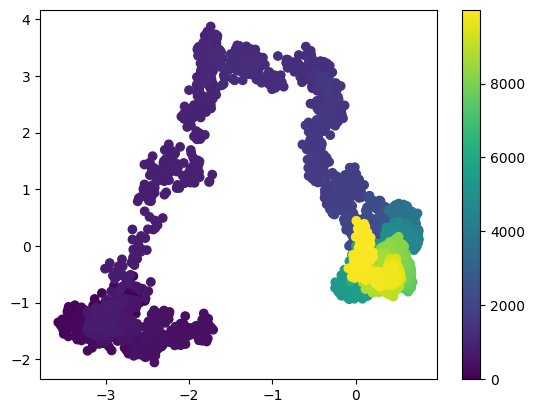

In [44]:
plt.scatter(prj1[:,0],prj1[:,1],c=range(10000))
plt.colorbar()

It looks like *this* trajectory took 2000 frames (20 ns) to equilibrate. The paper dropped the first 70 ns. 

Note how (100 ns-70 ns)*3 = 90 ns = 90000 ps = 9000 snapshots.

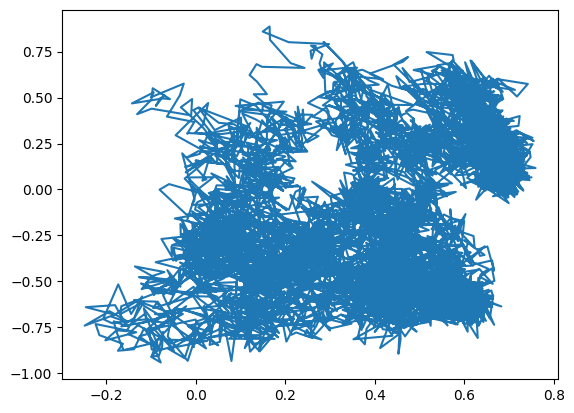

In [45]:
plt.plot(prj1[2000:,0],prj1[2000:,1])

## Concatenate the last part of each trajectory and repeat the analysis

Start taking data at L ns.

In [46]:
L = 70
lead_in = int(L*1000/10)
print(lead_in)

t1c = t1[lead_in:]
t2c = t2[lead_in:]
t3c = t3[lead_in:]
t123c = mdt.join([t1c,t2c,t3c])

7000


In [47]:
t123c

<mdtraj.Trajectory with 9000 frames, 588 atoms, 38 residues, and unitcells at 0x7fdb0c61a2b0>

In [48]:
cont1, _ = mdt.compute_contacts(t1c)
cont2, _ = mdt.compute_contacts(t2c)
cont3, _ = mdt.compute_contacts(t3c)

cont123, _ = mdt.compute_contacts(t123c)
# i.e.   np.vstack([cont1,cont2,cont3])

In [49]:
tica123 = TICA(dim=2, lagtime=5).fit(cont123).fetch_model()
p1=tica123.transform(cont1)
p2=tica123.transform(cont2)
p3=tica123.transform(cont3)

p123 = np.vstack([p1,p2,p3])

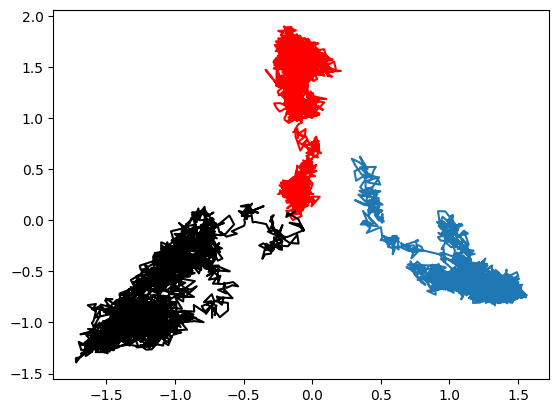

In [50]:
f, ax = plt.subplots(1)
ax.plot(p1[:,0],p1[:,1])
ax.plot(p2[:,0],p2[:,1],c="red")
ax.plot(p3[:,0],p3[:,1],c="black")


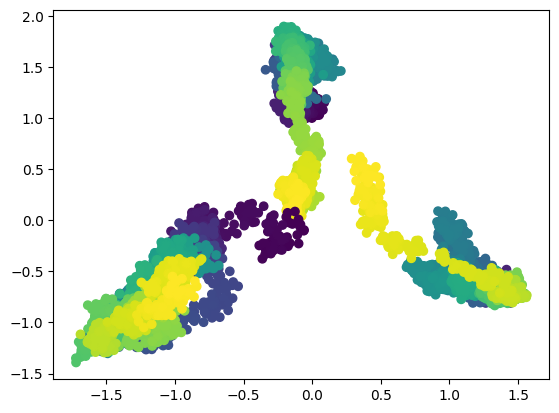

In [51]:
f, ax = plt.subplots(1)
ax.scatter(p1[:,0],p1[:,1], c=range(t1c.n_frames))
ax.scatter(p2[:,0],p2[:,1],c=range(t2c.n_frames))
ax.scatter(p3[:,0],p3[:,1],c=range(t3c.n_frames))
# Time goes dark to light
# f.colorbar() 

## Clustering

In [72]:
K = 100
cls = dt.clustering.KMeans(n_clusters=K).fit(p123).fetch_model()

## Transition counts

In [73]:
transition_counts = dt.markov.TransitionCountEstimator(lagtime=1,
                                                       count_mode="sliding").fit_fetch(
    [cls.transform(p1),
     cls.transform(p2),
     cls.transform(p3) ]
)

<BarContainer object of 100 artists>

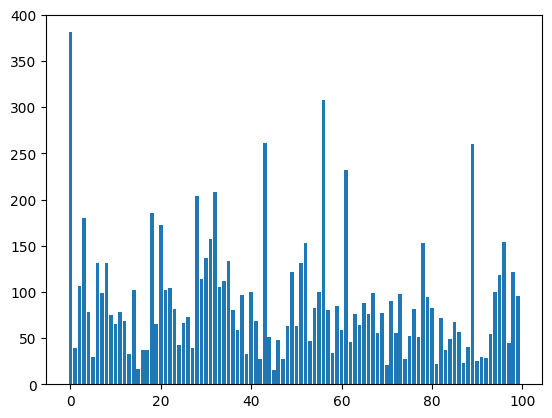

In [74]:
plt.bar(np.arange(len(transition_counts.state_histogram)),
        transition_counts.state_histogram)

In [75]:
msm_estimator = dt.markov.msm.MaximumLikelihoodMSM(reversible=True)
model = msm_estimator.fit_fetch(transition_counts)

In [76]:
model

MarkovStateModelCollection-140578525844816:[{'count_models': None,
                                            'reversible': True,
                                            'stationary_distributions': None,
                                            'transition_matrices': None,
                                            'transition_matrix_tolerance': 1e-06}]

In [77]:
model.stationary_distribution

array([0.03721591, 0.0251952 , 0.02616189, 0.02281942, 0.02197683,
       0.00596438, 0.01301733, 0.03580753, 0.03494429, 0.02845222,
       0.01199665, 0.02561074, 0.01369509, 0.02696253, 0.03405813,
       0.00471297, 0.03510764, 0.01792998, 0.00496877, 0.01511708,
       0.02211168, 0.01404566, 0.02914855, 0.02655389, 0.01618766,
       0.02249047, 0.03038351, 0.02347209, 0.03160887, 0.01966024,
       0.03442168, 0.00947498, 0.01819013, 0.01791262, 0.03175964,
       0.02526731, 0.01276615, 0.01721642, 0.02192723, 0.00805303,
       0.01310401, 0.01916551, 0.03510654, 0.01577961, 0.04247792])

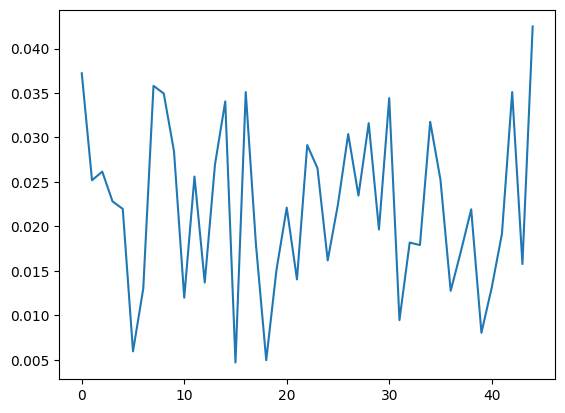

In [78]:
plt.plot(model.stationary_distribution)

In [79]:
dt.markov.compute_connected_sets(transition_counts.count_matrix)

[array([ 2,  4,  9, 10, 12, 15, 16, 21, 22, 23, 24, 26, 27, 36, 38, 39, 40,
        44, 45, 46, 50, 53, 54, 57, 62, 64, 65, 69, 71, 72, 73, 74, 75, 77,
        79, 82, 83, 84, 85, 87, 88, 93, 94, 97, 98]),
 array([ 0,  7, 11, 14, 19, 30, 31, 32, 33, 37, 43, 55, 56, 58, 63, 68, 76,
        80, 89, 92, 96]),
 array([ 3,  6, 18, 20, 28, 29, 34, 35, 41, 49, 51, 52, 59, 60, 61, 67, 78,
        86, 95]),
 array([ 1,  8, 17, 25, 48, 66, 81, 90, 99]),
 array([13, 42, 47, 91]),
 array([ 5, 70])]

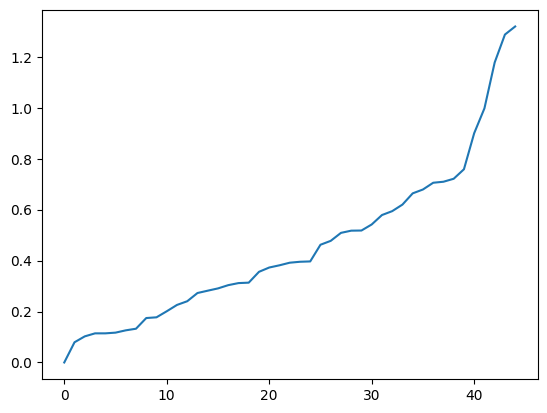

In [82]:
# Stationary distribution as dG, sorted
# 0.6 is kB*T in kcal/mol at room temperature
dG= -0.6*np.log(model.stationary_distribution)
dG=dG-np.min(dG)
plt.plot(sorted(dG))

In [96]:
# Let's find the most populated states, e.g. dG<0.2 kcal/mol
low_dG_states = np.where(dG<0.2)
low_dG_states

(array([ 0,  7,  8, 14, 16, 28, 30, 34, 42, 44]),)

In [97]:
# These refer to the largest connected component. Map back to the original 
# set of states (obtained from the clustering)
used_clusters = model.state_symbols()
used_clusters

array([ 2,  4,  9, 10, 12, 15, 16, 21, 22, 23, 24, 26, 27, 36, 38, 39, 40,
       44, 45, 46, 50, 53, 54, 57, 62, 64, 65, 69, 71, 72, 73, 74, 75, 77,
       79, 82, 83, 84, 85, 87, 88, 93, 94, 97, 98])

In [98]:
low_dG_clusters = used_clusters[low_dG_states]
low_dG_clusters

array([ 2, 21, 22, 38, 40, 71, 73, 79, 94, 98])

In [99]:
# Now map back to the frames, i.e. find which frames ended in one
# of the clusters above.
c123 = cls.transform(p123)

In [101]:
np.where(np.isin(c123, low_dG_clusters))

(array([6184, 6187, 6188, ..., 8946, 8951, 8955]),)